# <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Telco Customer Churn Classification</div></center></span>

<center>
<img src="https://images.unsplash.com/photo-1611599281058-94426d0618a7?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80" alt="Telco Customer Churn" width="50%">
<figcaption>Photo by <a href="https://unsplash.com/@sigmund?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Sigmund</a> on <a href="https://unsplash.com/photos/r9PeXDCJyEw?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  </figcaption>
</center>

## Bussiness Understanding

Telecom Churn Classification is the process of predicting whether a telecom customer is likely to leave or stay with the service provider. This information is critical for the telecom industry as retaining existing customers is more cost-effective than acquiring new ones.

In this problem, the aim is to build a machine learning model that can predict whether a customer is likely to churn or not based on past customer behavior, demographic information, and other factors. This information can be used to target customers who are at a higher risk of leaving with retention offers and incentives.

A successful Telecom Churn Classification model can help the service provider identify and retain high-value customers, reduce customer churn, and increase customer lifetime value. By proactively addressing customer churn, the service provider can improve customer satisfaction and brand loyalty, leading to increased revenue and profits.

Overall, Telecom Churn Classification is a critical aspect of customer relationship management for the telecom industry, providing valuable insights into customer behavior and enabling service providers to take proactive measures to retain customers and improve their bottom line.

## Data Understanding

- CustomerID: A unique ID that identifies each customer.
- Gender: The customer’s gender: Male, Female
- Senior Citizen: Indicates if the customer is 65 or older: Yes, No
- Partner: Indicate if the customer has a partner: Yes, No
- Tenure: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.
- Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No
- Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.
- Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No
- Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.
- Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
- Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Import Necessary Library</div></center></span>

In [445]:
# Exploration purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Model related
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

# Data balancing
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Other
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Load Dataset</div></center></span>

In [98]:
# Download dataset (don't run if data exist)
url = "https://dqlab-dataset.s3-ap-southeast-1.amazonaws.com/dqlab_telco_final.csv"
dataset_dir = "./dataset/churn_telco.csv"
!curl $url --output $dataset_dir 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  446k  100  446k    0     0   903k      0 --:--:-- --:--:-- --:--:--  905k


In [99]:
# Import dataset
telco_churn_df = pd.read_csv(dataset_dir)
telco_churn_df.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Exploratory Data Analysis</div></center></span>

### Check Basic Data Info

In [100]:
# Check overall data 
telco_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpdatedAt         6950 non-null   int64  
 1   customerID        6950 non-null   int64  
 2   gender            6950 non-null   object 
 3   SeniorCitizen     6950 non-null   object 
 4   Partner           6950 non-null   object 
 5   tenure            6950 non-null   int64  
 6   PhoneService      6950 non-null   object 
 7   StreamingTV       6950 non-null   object 
 8   InternetService   6950 non-null   object 
 9   PaperlessBilling  6950 non-null   object 
 10  MonthlyCharges    6950 non-null   float64
 11  TotalCharges      6950 non-null   float64
 12  Churn             6950 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 706.0+ KB


In [101]:
# Check whether there is duplicates data
telco_churn_df.customerID.nunique()

6950

In [202]:
# Check whether there is null data
telco_churn_df.isnull().sum()

UpdatedAt           0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
tenure              0
PhoneService        0
StreamingTV         0
InternetService     0
PaperlessBilling    0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### See Label Distribution

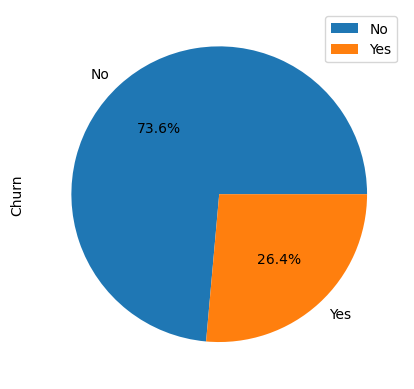

In [103]:
telco_churn_df['Churn'].value_counts().plot(kind='pie', legend=telco_churn_df['Churn'].value_counts, autopct='%1.1f%%', )
plt.show()

From the plot above, we can see that the label are a bit imbalance with not-churn customers on 73.6% and churning customers on 26.4%.  So the prediction result of machine learning's will probably be biased towards not-churn customers.

### Handling Outliers

First, let's see if there's any outliers

<AxesSubplot:xlabel='MonthlyCharges'>

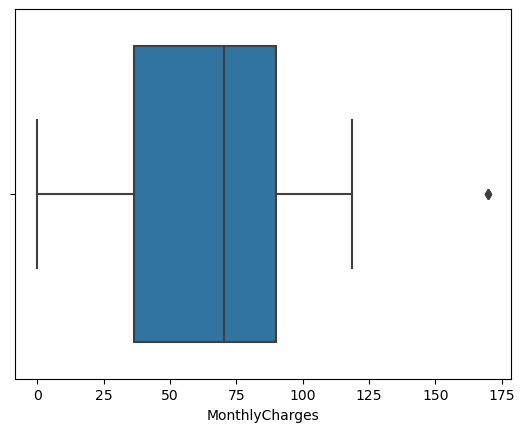

In [104]:
sns.boxplot(x=telco_churn_df['MonthlyCharges'])

<AxesSubplot:xlabel='tenure'>

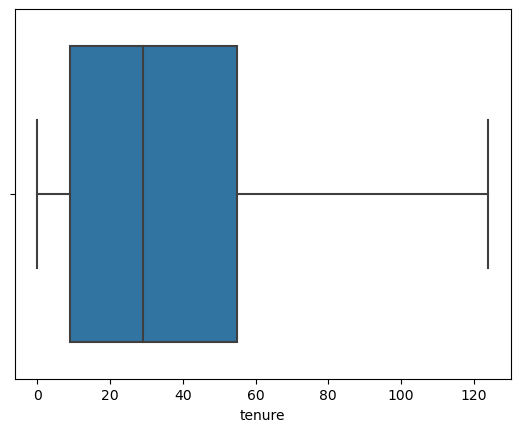

In [105]:
sns.boxplot(x=telco_churn_df['tenure'])

<AxesSubplot:xlabel='TotalCharges'>

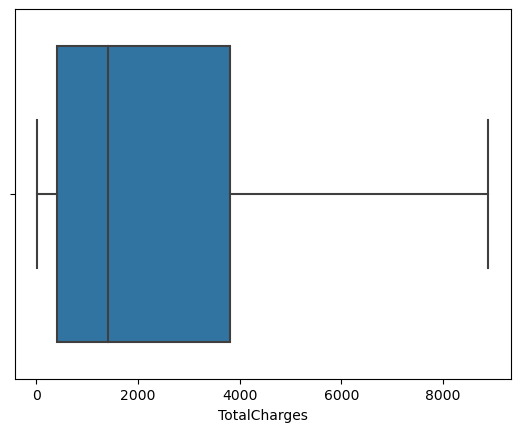

In [106]:
sns.boxplot(x=telco_churn_df['TotalCharges'])

In [107]:
# Use IQR Method to get rid of outliers
Q1 = telco_churn_df.quantile(0.25)
Q3 = telco_churn_df.quantile(0.75)

IQR = Q3 - Q1
telco_churn_df=telco_churn_df[~((telco_churn_df<(Q1-1.5*IQR))|(telco_churn_df>(Q3+1.5*IQR))).any(axis=1)]

# Check if outlier have been dropped
telco_churn_df.shape

(6947, 13)

### Numerical Features Exploratory

In [108]:
# Define column that included numerical value
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

See numerical data distribution based on churn label

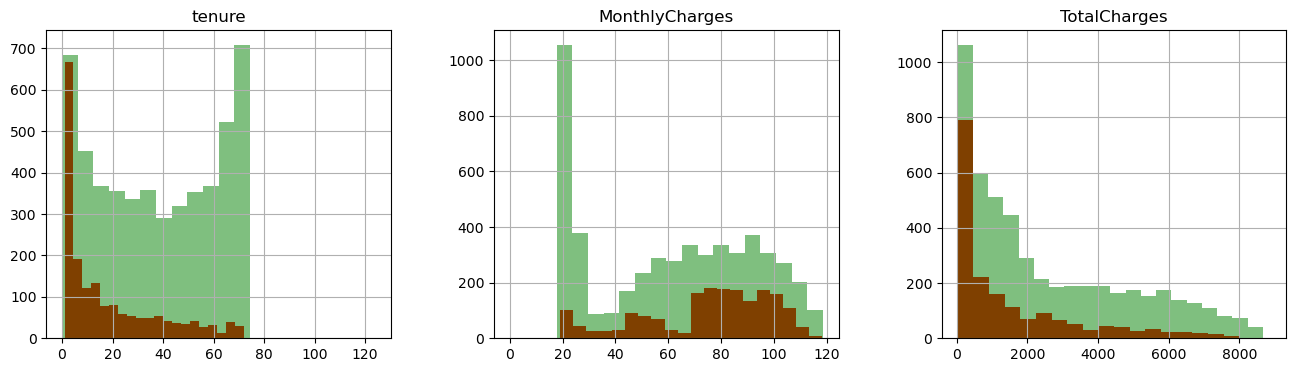

In [109]:
# Plot the two overlaying histogram per each numerical feature, with churning customer and not churn on green.
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
telco_churn_df[telco_churn_df['Churn'] == 'Yes'][numerical_features].hist(bins=20, color='red', ax=ax)
telco_churn_df[telco_churn_df['Churn'] == 'No'][numerical_features].hist(bins=20, color='green', alpha=0.5, ax=ax)
plt.show()

From these histograms we can see that:
1. People who have long tenure period usually stay subscribed, and most of churned customer have short tenure
2. Most of the not-churning customer paid the cheapest monthly charges on 25$, while most of the churning customer have monthly charges around 75-100$
3. Both of plot on the total charges shows that the data distribution is skewed-right and people mostly tend to have cheaper total charges.  This align with the previous plot which show most people spend money on cheaper monthly payments


Next, we want to see correlation between each features

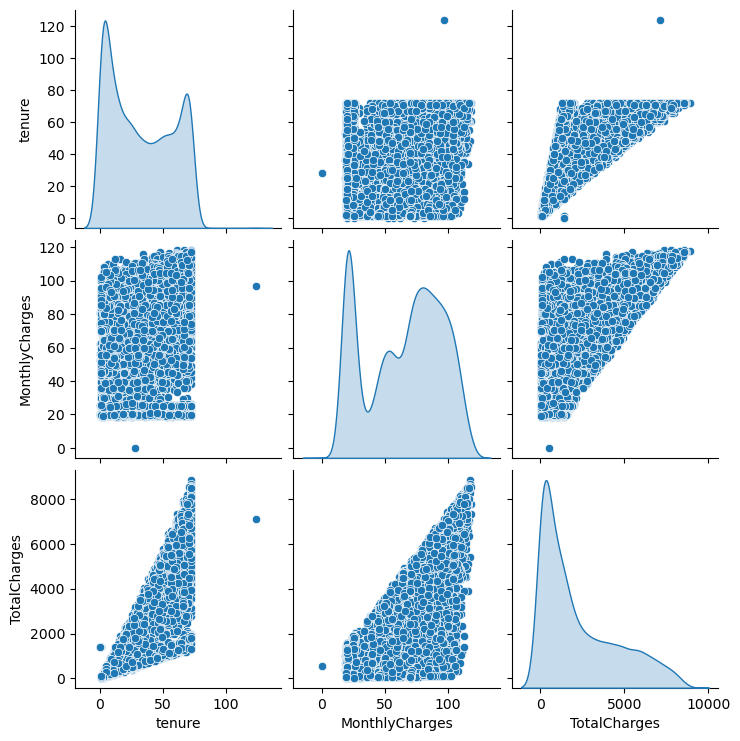

In [111]:
sns.pairplot(telco_churn_df[numerical_features], diag_kind='kde')

From the pairplot above we can see that each of the features made some kind of shape, which show that they have certain value of correlation.  To further evaluate the correlation we can use confusion matrix below.

Text(0.5, 1.0, 'Correlation Matrix for numeric features')

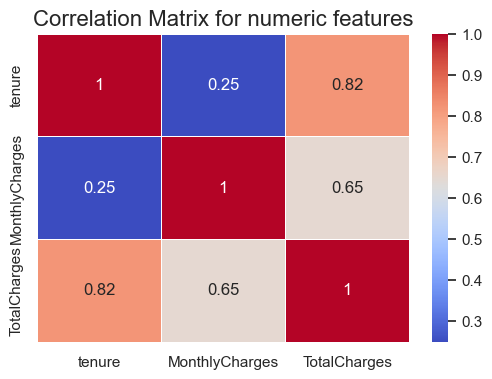

In [231]:
plt.figure(figsize=(6, 4))
correlation_matrix = telco_churn_df[numerical_features].corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for numeric features", size=16)

From the correlation above, we can see that each of the variable are tightly correlated with tenure and monthly charges have the least correlation.  But still, we don't have to drop any of the feature or anything.

### Categorical Data Exploratory

In [186]:
# Define column that included categorical value
categorical_features = telco_churn_df.select_dtypes(include='object').columns.tolist()
label = categorical_features[7]

# Remove label from features
categorical_features.pop()
categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'PhoneService',
 'StreamingTV',
 'InternetService',
 'PaperlessBilling']

In [187]:
label

'Churn'

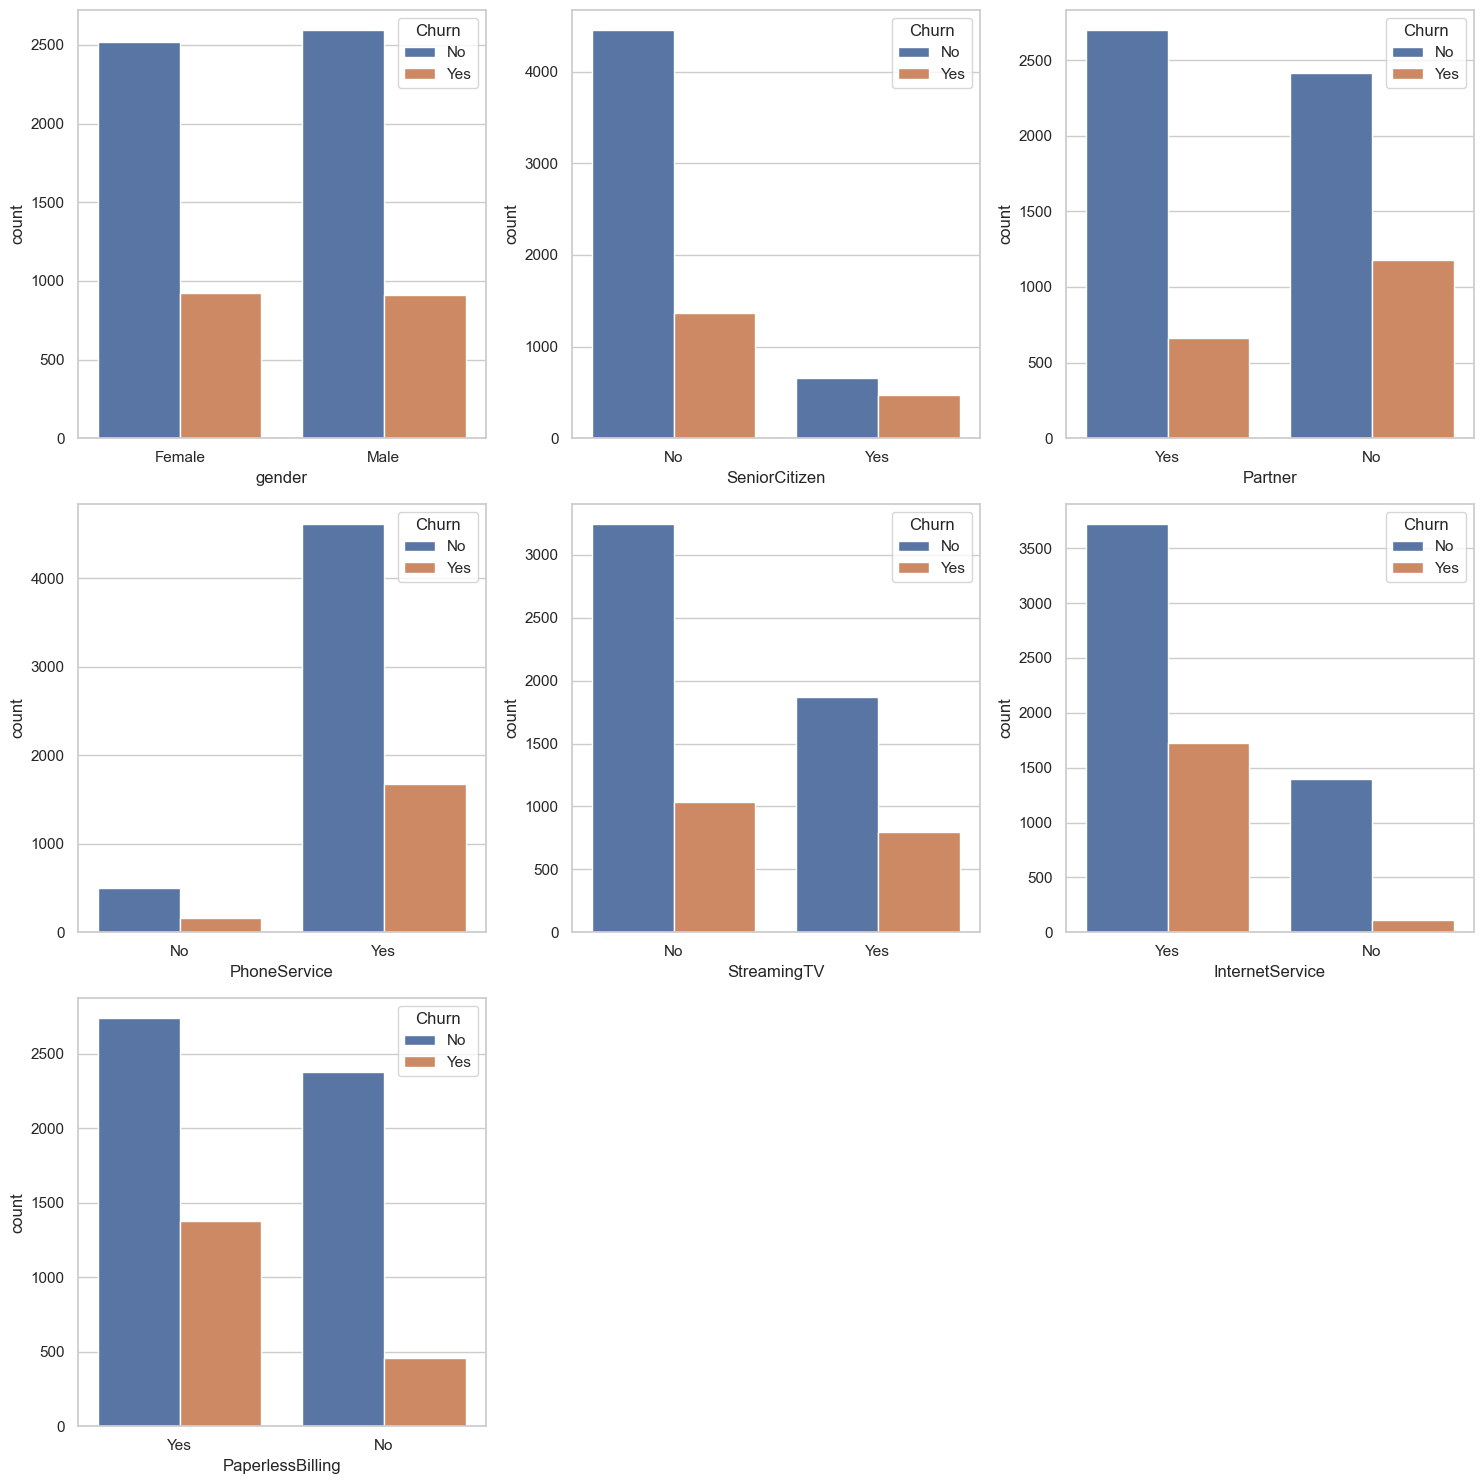

In [276]:
# Define the number of columns and rows for the subplots
sns.set(style='whitegrid')

ncols = 3
nrows = int(np.ceil(len(categorical_features) / ncols))

# Define the figure size
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Flatten the 2-dimensional array of axes
axs = axs.ravel()

# Loop through the categorical features
for i, col in enumerate(categorical_features):
    sns.countplot(data=telco_churn_df, x=col, hue=label, ax=axs[i])

# Remove empty subplots
for i in range(len(categorical_features), nrows * ncols):
    fig.delaxes(axs[i])

# Show the subplots
plt.tight_layout()
plt.show()

From these countplots, we can draw some conclusion:
1. From gender and phone service factor it doesn't seem to impact on whether they churn
2. People who tend to churn are people who don't have partner(partner: No), a senior citizen (SeniorCitizen: yes), people with streaming tv (StreamingTV: yes), people with (InternetService: yes) and people with paperless billing(PaperlessBilling: yes)

## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Data Preparation and Feature Engineering</div></center></span>

### Delete Unnecesary Columns

In [321]:
cleaned_df = telco_churn_df.drop(columns=['UpdatedAt', 'customerID'])
cleaned_df

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No
...,...,...,...,...,...,...,...,...,...,...,...
6945,Male,No,No,1,Yes,No,Yes,Yes,44.75,44.75,No
6946,Female,Yes,No,1,Yes,No,Yes,Yes,70.15,70.15,Yes
6947,Female,No,No,1,Yes,Yes,Yes,Yes,85.55,85.55,Yes
6948,Female,No,Yes,72,Yes,Yes,Yes,Yes,117.15,8529.50,No


### Label Encoding
In order for machine learning models able to process our data, we need to convert categorical data into numeric with label encoding.  This can be achieved by using sklearn's LabelEncoder()

In [322]:
le = LabelEncoder()
for col in cleaned_df:
    if cleaned_df[col].dtypes == 'object':
        cleaned_df[col] = le.fit_transform(cleaned_df[col])

In [323]:
# We can see that all the object dtype has been converted to numeric
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6947 entries, 0 to 6949
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            6947 non-null   int32  
 1   SeniorCitizen     6947 non-null   int32  
 2   Partner           6947 non-null   int32  
 3   tenure            6947 non-null   int64  
 4   PhoneService      6947 non-null   int32  
 5   StreamingTV       6947 non-null   int32  
 6   InternetService   6947 non-null   int32  
 7   PaperlessBilling  6947 non-null   int32  
 8   MonthlyCharges    6947 non-null   float64
 9   TotalCharges      6947 non-null   float64
 10  Churn             6947 non-null   int32  
dtypes: float64(2), int32(8), int64(1)
memory usage: 692.2 KB


### Feature Selection

Feature selection for categorical features, using Chi-Squared test:

Text(0.5, 1.0, 'Selection of Categorical Features')

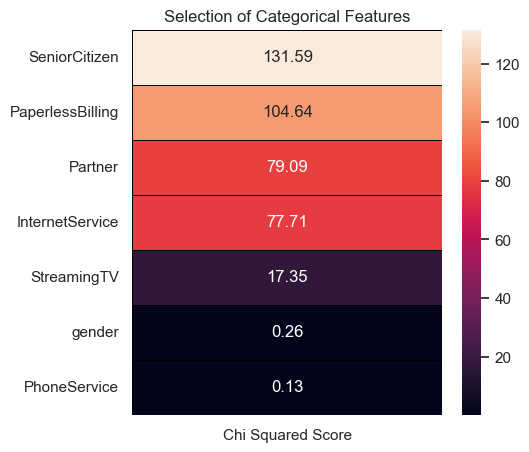

In [326]:
features = cleaned_df.loc[:,categorical_features]
label = cleaned_df['Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features, label)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True, linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Categorical Features')

From the Chi Squared One result above, we can see that gender and PhoneService diplay pretty low correlation (0.x) so we can drop it as well

In [327]:
cleaned_df = cleaned_df.drop(columns=['gender', 'PhoneService'])
cleaned_df.head()

,SeniorCitizen,Partner,tenure,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,0,1,0.008065,0,1,1,0.251686,0.001223,0
1,0,1,0.483871,0,0,1,0.172850,0.133008,0
2,0,0,0.040323,1,1,0,0.877740,0.058951,1
3,0,1,0.580645,1,1,1,0.973862,0.935020,0
4,0,1,0.451613,1,1,0,0.685076,0.518752,0


Feature selection for numerical features, using ANOVA test:

Text(0.5, 1.0, 'Selection of Numerical Features')

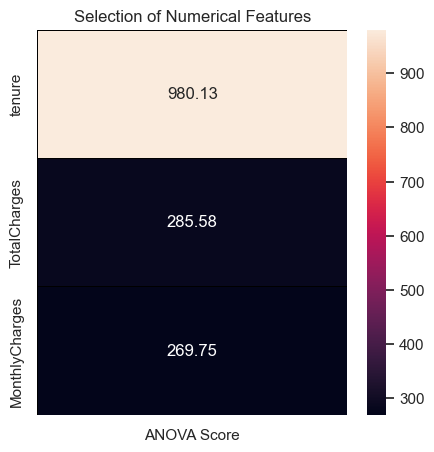

In [334]:
features = cleaned_df.loc[:,numerical_features]
label = cleaned_df.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features, label)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True, linewidths = 0.4,linecolor = 'black',fmt = '.2f')
plt.title('Selection of Numerical Features')

The higher the value of ANOVA Score, the higher the importance of feature.  So based on the above result, we can include all the numerical features

### Normalization
Normalization is done for features whose data does not display normal distribution.  Because the numerical feature such as tenure, MonthlyCharges and TotalCharges displayed a right-skewed and bimodal data distribution, we gonna normalize it using sklearn's MinMaxScaler.

In [324]:
mms = MinMaxScaler()
cleaned_df[numerical_features] = mms.fit_transform(cleaned_df[numerical_features])

In [328]:
cleaned_df.head()

,SeniorCitizen,Partner,tenure,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,0,1,0.008065,0,1,1,0.251686,0.001223,0
1,0,1,0.483871,0,0,1,0.172850,0.133008,0
2,0,0,0.040323,1,1,0,0.877740,0.058951,1
3,0,1,0.580645,1,1,1,0.973862,0.935020,0
4,0,1,0.451613,1,1,0,0.685076,0.518752,0


### Data Balancing with SMOTE

- In order to cope with unbalanced data, there are 2 options :

    - **Undersampling** : Trim down the majority samples of the target variable.
    - **Oversampling** : Increase the minority samples of the target variable to the majority samples.
    
    
- After doing trial-error with undersampling & oversampling, we have decided to go with oversampling!
- For data balancing, we will use **imblearn**.
    - **pip statement** : pip install imbalanced-learn

In [449]:
over = SMOTE(sampling_strategy = 1)

f1 = cleaned_df.iloc[:,:8].values
t1 = cleaned_df.iloc[:,8].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)

Counter({0: 5111, 1: 5111})

### Train Test Split

In [329]:
X = cleaned_df.drop(columns='Churn')
y = cleaned_df['Churn']

In [453]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(f1, t1, test_size=0.3, random_state=42)

In [458]:
# Check each sample of splitted data
print(f'Total # of sample in whole dataset: {len(f1)}')
print('=========================================')
print(f'Total # of sample in train dataset: {len(X_train)}')
print('=========================================')
print(f'Total # of sample in test dataset: {len(X_test)}')


Total # of sample in whole dataset: 10222
Total # of sample in train dataset: 7155
Total # of sample in test dataset: 3067


## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Model Building and Evaluation</div></center></span>

Because our classification problem are just binary classification, we'll try some simple classification algorithm such as Logistic Regression, Decision Tree, Random Forest, Support Vector Machines, and Naive Bayes Classifier.

In [459]:
# Define function to train models
def train_model(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test, y_pred)))
    plot_roc_curve(classifier, X_test, y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

# Define function to evaluate models
def evaluate_model(classifier, X_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test, classifier.predict(X_test)))

### Logistic Regression Model

In [460]:
lr_model = LogisticRegression()

Cross Validation Score :  81.81%
ROC_AUC Score :  75.13%


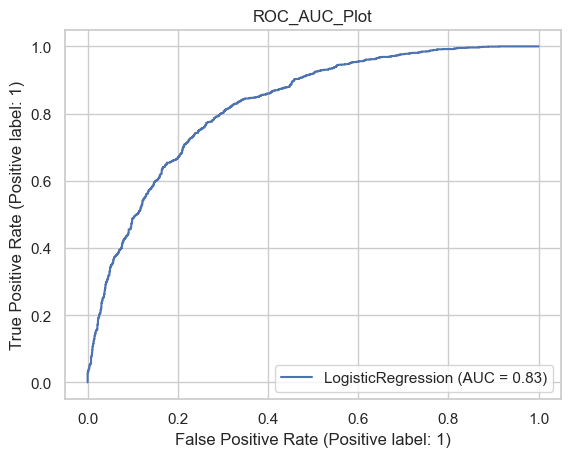

In [461]:
train_model(lr_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1571
           1       0.73      0.78      0.75      1496

    accuracy                           0.75      3067
   macro avg       0.75      0.75      0.75      3067
weighted avg       0.75      0.75      0.75      3067



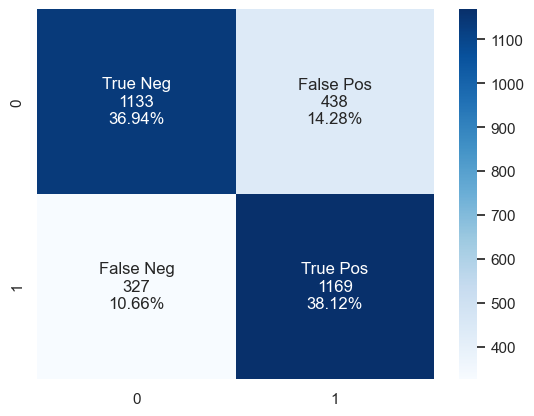

In [462]:
evaluate_model(lr_model, X_test, y_test)

In [584]:
# Save score to variable
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
lr_cv = np.round(cross_val_score(lr_model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()*100, 2)
lr_roc = round(roc_auc_score(y_test, lr_model.predict(X_test))*100, 2)
lr_f1 = round(f1_score(y_test, lr_model.predict(X_test))*100, 2)

### Decision Tree Model

In [464]:
dt_model = DecisionTreeClassifier(random_state = 42, max_depth = 4, min_samples_leaf = 1)

Cross Validation Score :  81.36%
ROC_AUC Score :  75.89%


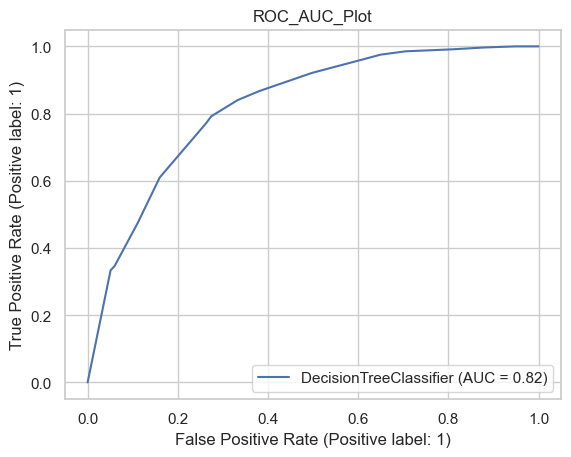

In [465]:
train_model(dt_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.79      0.73      0.75      1571
           1       0.73      0.79      0.76      1496

    accuracy                           0.76      3067
   macro avg       0.76      0.76      0.76      3067
weighted avg       0.76      0.76      0.76      3067



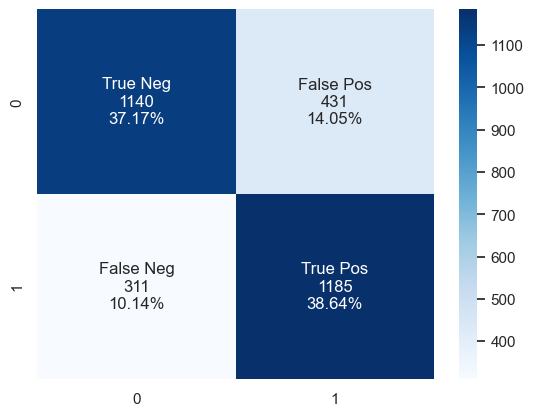

In [466]:
evaluate_model(dt_model, X_test, y_test)

In [585]:
# Save score to variable
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_cv = np.round(cross_val_score(dt_model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()*100, 2)
dt_roc = round(roc_auc_score(y_test, dt_model.predict(X_test))*100, 2)
dt_f1 = round(f1_score(y_test, dt_model.predict(X_test))*100, 2)

### Random Forest Model

In [468]:
rf_model = RandomForestClassifier(max_depth=4, random_state=0)

Cross Validation Score :  82.80%
ROC_AUC Score :  75.16%


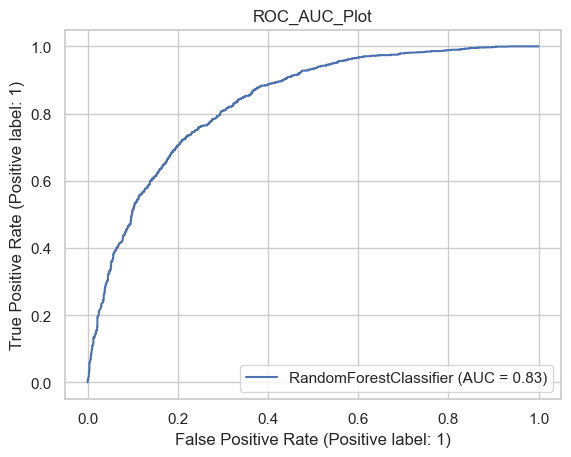

In [469]:
train_model(rf_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1571
           1       0.72      0.79      0.76      1496

    accuracy                           0.75      3067
   macro avg       0.75      0.75      0.75      3067
weighted avg       0.75      0.75      0.75      3067



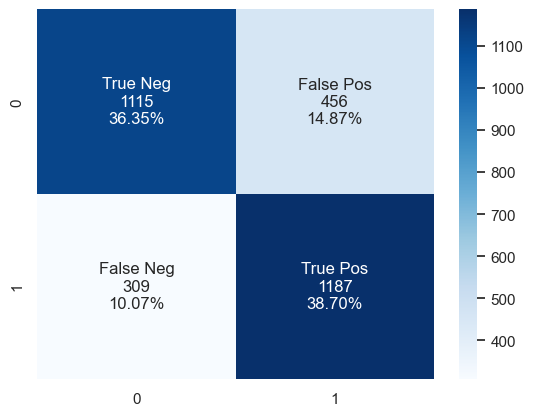

In [470]:
evaluate_model(rf_model, X_test, y_test)

In [581]:
# Save score to variable
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rf_cv = np.round(cross_val_score(rf_model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()*100, 2)
rf_roc = round(roc_auc_score(y_test, rf_model.predict(X_test))*100, 2)
rf_f1 = round(f1_score(y_test, rf_model.predict(X_test))*100, 2)

### Support Vector Classifier

In [472]:
svm_model = SVC(random_state=1)

Cross Validation Score :  81.28%
ROC_AUC Score :  74.79%


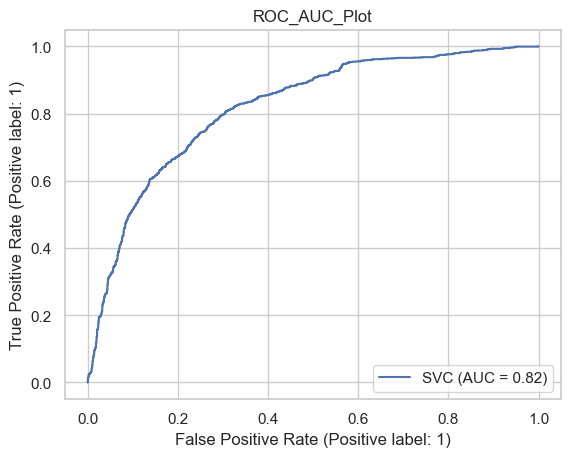

In [473]:
train_model(svm_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1571
           1       0.72      0.80      0.75      1496

    accuracy                           0.75      3067
   macro avg       0.75      0.75      0.75      3067
weighted avg       0.75      0.75      0.75      3067



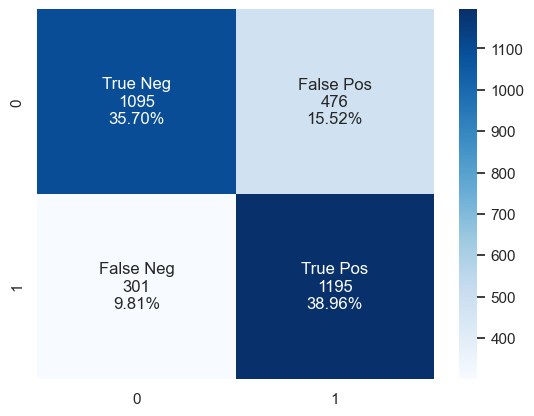

In [475]:
evaluate_model(svm_model, X_test, y_test)

In [560]:
# Save score to variable
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
svm_cv = np.round(cross_val_score(svm_model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()*100, 2)
svm_roc = np.round(roc_auc_score(y_test, svm_model.predict(X_test))*100, 2)
svm_f1 = np.round(f1_score(y_test, svm_model.predict(X_test))*100, 2)

### Naive Bayes Classifier

In [478]:
nb_model = GaussianNB()

Cross Validation Score :  78.83%
ROC_AUC Score :  72.54%


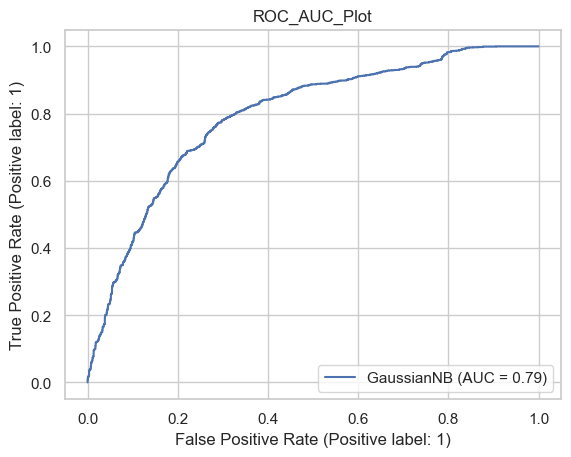

In [479]:
train_model(nb_model, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.79      0.62      0.70      1571
           1       0.68      0.83      0.74      1496

    accuracy                           0.72      3067
   macro avg       0.73      0.73      0.72      3067
weighted avg       0.74      0.72      0.72      3067



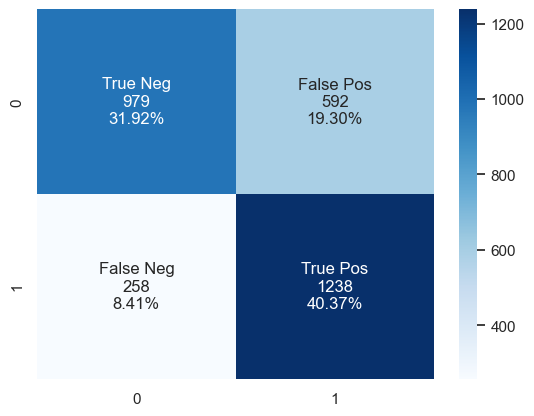

In [480]:
evaluate_model(nb_model, X_test, y_test)

In [579]:
# Save score to variable
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
nb_cv = np.round(cross_val_score(nb_model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()*100, 2)
nb_roc = round(roc_auc_score(y_test, nb_model.predict(X_test))*100, 2)
nb_f1 = round(f1_score(y_test, nb_model.predict(X_test))*100, 2)

## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Algorithm Result</div></center></span>

In [599]:

algo_result = {
    'Algorithm Name': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Classifier', 'Naive Bayes Classifier'],
    'Cross Validation Score (%)': [lr_cv, dt_cv, rf_cv, svm_cv, nb_cv],
    'ROC AUC Score (%)': [lr_roc, dt_roc, rf_roc, svm_roc, nb_roc],
    'F1 Score (%)': [lr_f1, dt_f1, rf_f1, svm_f1, nb_f1]
}
algo_result_df = pd.DataFrame(algo_result)
algo_name = pd.Series(algorithm_name)

In [600]:
algo_result_df

,Algorithm Name,Cross Validation Score (%),ROC AUC Score (%),F1 Score (%)
0,Logistic Regression,81.81,75.13,75.35
1,Decision Tree,81.36,75.89,76.16
2,Random Forest,82.80,75.16,75.63
3,Support Vector Classifier,81.28,74.79,75.47
4,Naive Bayes Classifier,78.83,72.54,74.44


In [601]:
algo_result_df

,Algorithm Name,Cross Validation Score (%),ROC AUC Score (%),F1 Score (%)
0,Logistic Regression,81.81,75.13,75.35
1,Decision Tree,81.36,75.89,76.16
2,Random Forest,82.80,75.16,75.63
3,Support Vector Classifier,81.28,74.79,75.47
4,Naive Bayes Classifier,78.83,72.54,74.44


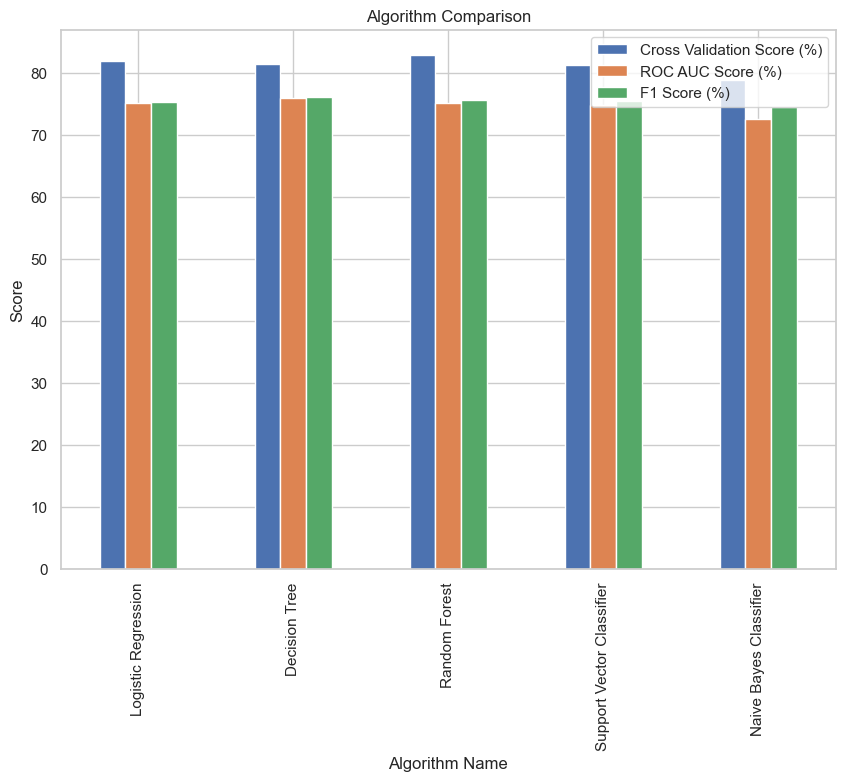

In [608]:
# Plot the algorithm result
algo_result_df.plot(kind='bar', figsize=(10, 7))
plt.xlabel('Algorithm Name')
plt.xticks(range(len(algo_name)), algo_name)
plt.ylabel('Score')
plt.title('Algorithm Comparison')
plt.show()

## <span><center><div style="font-family: Trebuchet MS; background-color: #eab676; color: #2D2926; padding: 12px; line-height: 1;">Conclusion</div></center></span>

- Working with this dataset is a bit challenging, one of the reasons is because of the imbalanced labels.  This is my first time using SMOTE analysis for data balancing and it boost the model performance by considerable amounts.
- Model performance could still be improved perhaps with hyperparameter tuning and cross validation.
- There are still more insight that could be gain by doing more detailed EDA